# Dummy Data Analysis, Project 81 Semiconductors Band Gap Determination using Optical Absorption/Transmission Technique

In this notebook I am going to import a sample Halogen spectrum as my $I_0$, from which I will attempt to create some sample dummy data and perform an analysis similar to what we would do with real data.

## The dummy data

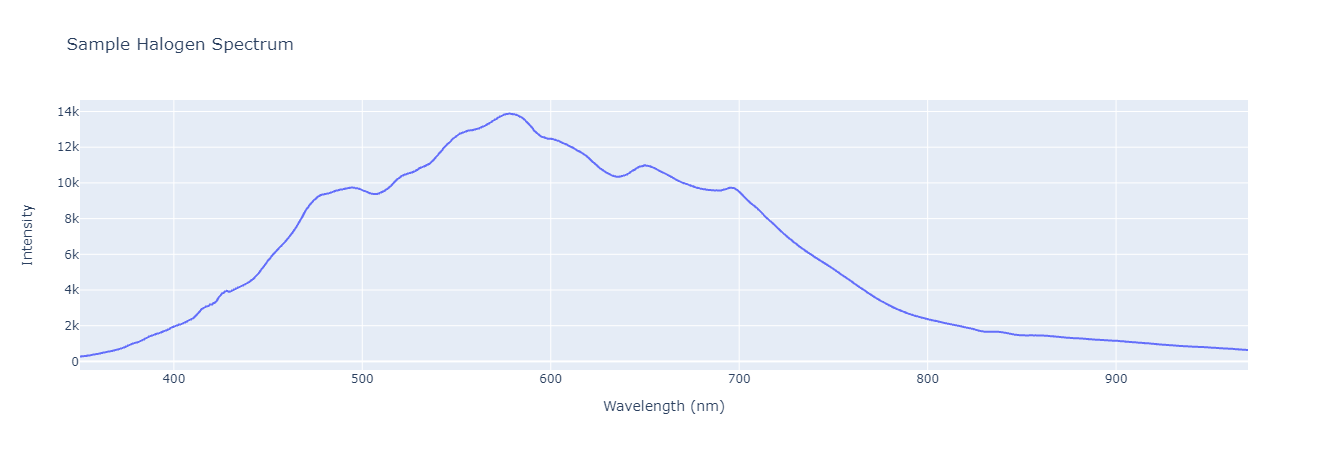

In [7]:
import pandas as pd
import plotly.express as px
import numpy as np
import scipy.constants as cn

df = pd.read_csv("data1.txt", sep = " ", encoding = 'UTF-8')

# Remove erroneous 'unnamed: 3' column 
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

fig = px.line(df, x="Wavelength", y="Signal", title='Sample Halogen Spectrum', labels = {
    "Wavelength": "Wavelength (nm)",
    "Signal":"Intensity"})
fig.show()

## Creating dummy values for $T$

Now we have a sample spectrum, would would like a Transmission Coefficient, $T$, which varies like:

![title](img/trans_coeff.png)

So we can the transmission coefficient for GaAs, $T = \frac{I}{I_0}$, shoots up at a wavelength $\lambda$ of around 895nm, and levels off at a peak $T$ of around 0.5.

We can approximate such a curve using the following piecewise function

$$
\begin{split}
    T = 0 \qquad &\lambda \lt a + 1 \\
    T = \frac{(\lambda - a)^n}{(\lambda - a)^n + 1} - b \qquad &\lambda \geq a + 1
\end{split}
$$

where

$$
\begin{split}
    a &= 894 \\
    n &= 1 \\
    b &= 0.5
\end{split}
$$

Plotting this piecewise equation across our range of wavelengths for $I_0$ gives us the following graph:

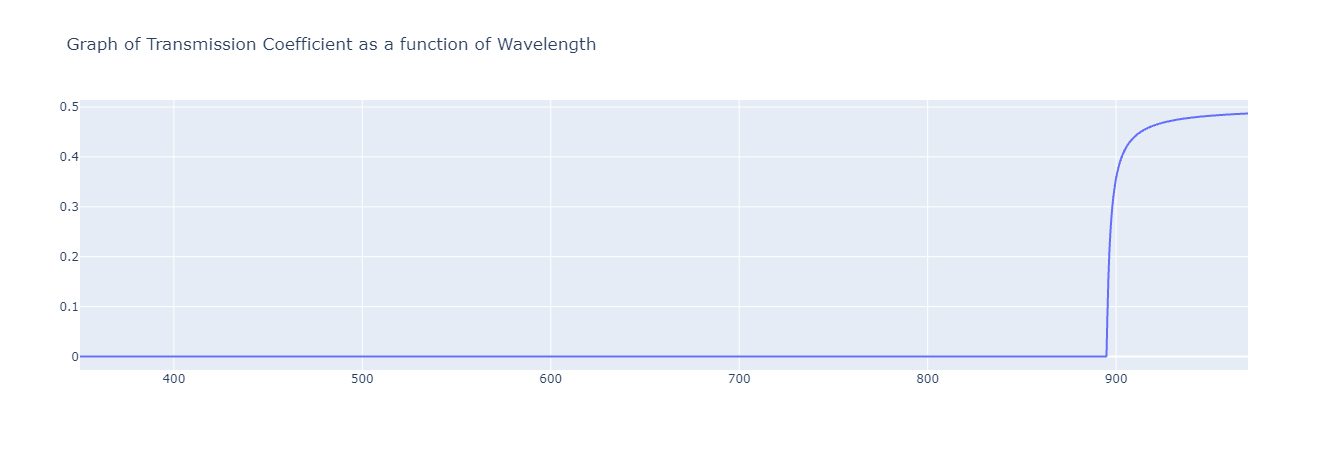

In [8]:
a = 894
n = 1
b = 0.5

x = df["Wavelength"].values
y = df["Signal"].values

T = np.piecewise(x, [x < a+1, x >= a+1], [0, lambda x: ((x-a)**n)/((x-a)**n+1)-b])

fig1 = px.line(x = x, y = T, title = "Graph of Transmission Coefficient as a function of Wavelength",
              labels = {
                 "x" : r"$\lambda \; \text{(nm)}$",
                 "y" : r"$T$"
             })
fig1.show()

## Generating a more realistic $T$

To a decent approximation, this is a similar shape of curve as in the Figure. Since we aren't working with ideal data, it would be good to add some noise to this mask:

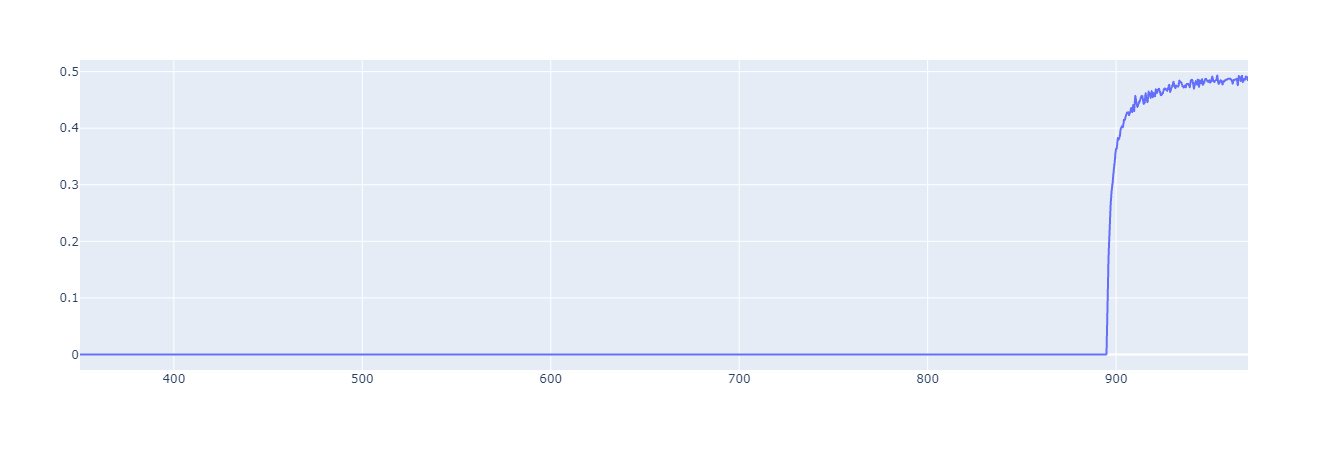

In [9]:
# Get first index of mask being greater than 0
index = np.where(T > 0)[0][0]

# Get length of non-zero slice
nonzero_length = len(T[index :])

# Generate noise
noise = np.random.normal(0,0.005,nonzero_length)

# Generate original mask
T = np.piecewise(x, [x < a+1, x >= a+1], [0, lambda x: ((x-a)**n)/((x-a)**n+1)-b])

# Generate noisy mask
T_noisy = T
T_noisy[index : ] += noise

# Plot
fig2 = px.line(x = x, y = T_noisy,
              labels = {
                 "x" : r"$\lambda \; \text{(nm)}$",
                 "y" : r"$T$"
             })
fig2.show()

This looks more in line with what we would see in an experiment. We can now work backwards and see the spectrum, $I$, which would generate such values of $T$:

In [4]:
# Generate masked signal and add it to the dataframe
signal_masked = df["Signal"].values * T_noisy

df.insert(loc=len(df.columns), column = "I", value = signal_masked)

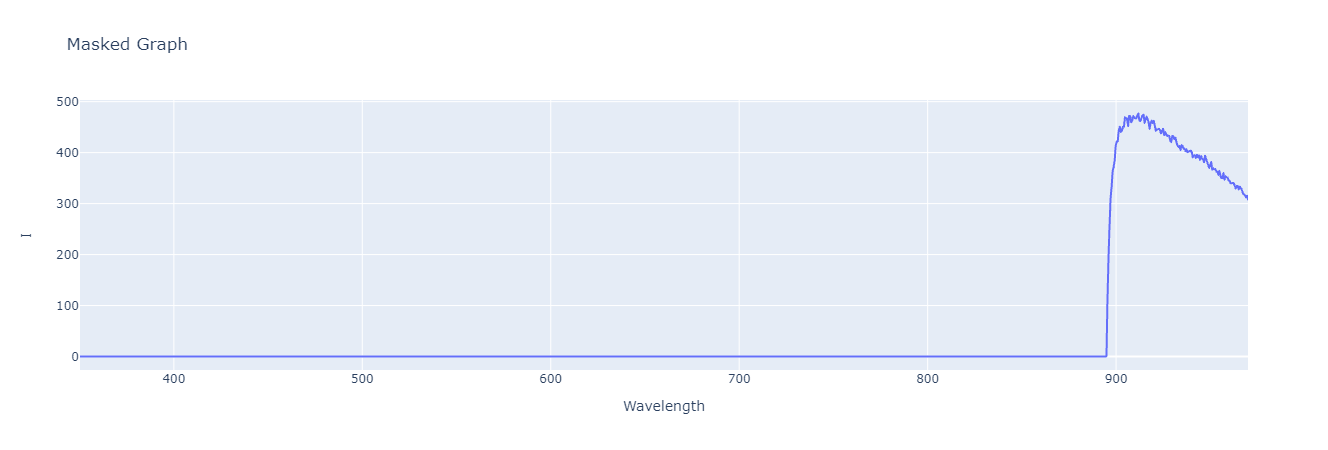

In [5]:
fig3 = px.line(df, x="Wavelength", y="I", title='Masked Graph')

fig3.show()

So when measuring $I$ at some value of $T$, we would expect the shape of the $I$ to be similar to that above. If we compare $I$ and $I_0$:

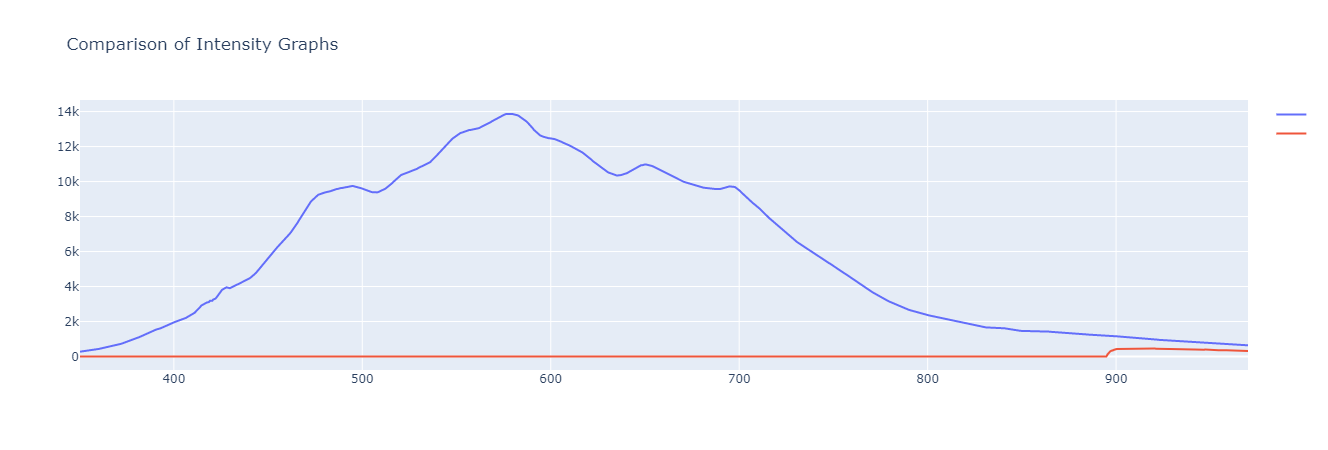

In [6]:
import plotly.graph_objects as go

fig4 = go.Figure()
fig4.add_trace(go.Scatter(x = df["Wavelength"], y = df["Signal"], mode = "lines", name = r"$I_0$"))
fig4.add_trace(go.Scatter(x = df["Wavelength"], y = df["I"], mode = "lines", name = r"$I$"))

fig4.update_layout(
    title="Comparison of Intensity Graphs",
    xaxis_title=r"$\lambda \; \text{(nm)}$",
    yaxis_title=r"$I \; \text{(counts)}$",
)

fig4.show()

Unsurprisingly, we would expect a much smaller intensity graph when shining the halogen white light through the GaAs sample.

<h3> Analysis from $T$ to $E_g$ </h3>

### Generating R

The next thing we want to do is find the reflectance, $R$. First, we want to delete all zero values from T, as this will make things easier later on.

In [7]:
# Find first nonzero element as before
index = np.where(T > 0)[0][0]

# Create new slices of T and Wavelength
wavelength = (df["Wavelength"].values)[index :]
T = T_noisy[index :]

The transmission coefficient, $T$, is given by the following equation:

$$
T = \frac{(1 - R)^2 \, e^{- \alpha x}}{1 -R^2 \, e^{-2 \alpha x}}
$$

The long-wavelength region where $T$ approaches a known value is known as the transparent region, and occurs when $\alpha = 0$. In this region the equation for $T$ becomes

$$
T = \frac{(1 - R)^2}{1 -R^2} = \frac{(1-R)(1-R)}{(1+R)(1-R)} = \frac{1-R}{1+R}
$$

and hence

$$
R = \frac{1-T}{1+T}
$$



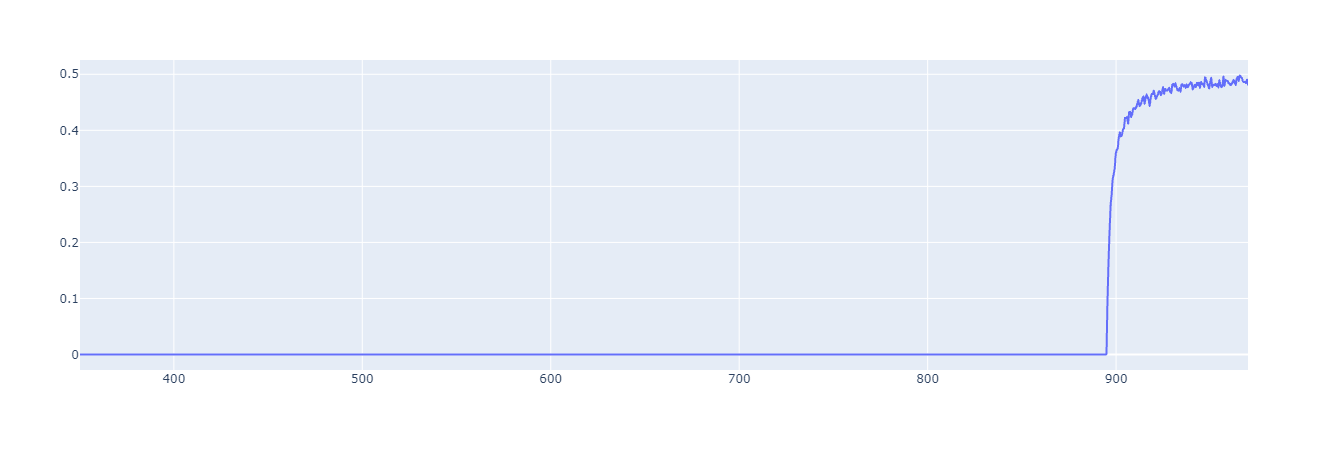

In [8]:
fig2.show()

Finding the $T$ value for this transparent region can be done by taking the mean of the linear region. Selecting the start of this linear region can be done manually by eye. In our case the data looks linear after $\lambda \approx 980$ nm.

In [9]:
# Find the index of wavelength where wavelength > 980
cutoff = 920
i_transp = np.where(wavelength > cutoff)[0][0]

# Take a slice of the T data according to this index
T_linear = T[i_transp :]

# Our value of T in this linear region is the mean of this array
T_transp = np.mean(T_linear)

print(T_transp)

0.4802539689455985


We know the answer is supposed to be $T \approx 0.5$, so let's use this calculated value. Sub into $R = \frac{1-T}{1+T}$:

In [10]:
R = (1 - T_transp)/(1 + T_transp)

print(R)

0.35111949838217454


This is similar to what the paper finds, which is $R = 0.33 \pm 0.01$. With this value of R, and taking the thickness of the GaAs to be $x = 0.50 \pm 0.03$mm, we can then calculate the absorption coefficient $\alpha$, which is given by the following equation

$$
    \alpha = -\frac{1}{x} ln \Bigg[\frac{1}{2TR^2}\bigg(\Big[(1-R)^4 + 4T^2 R^2\Big]^{\frac{1}{2}} - (1-R)^2\bigg)\Bigg]
$$

In [11]:
x = 0.50e-3

alpha = -1/x *np.log( 1/(2*T*R**2) * (((1-R)**4 + 4 * T**2 * R**2)**(1/2) - (1-R)**2))

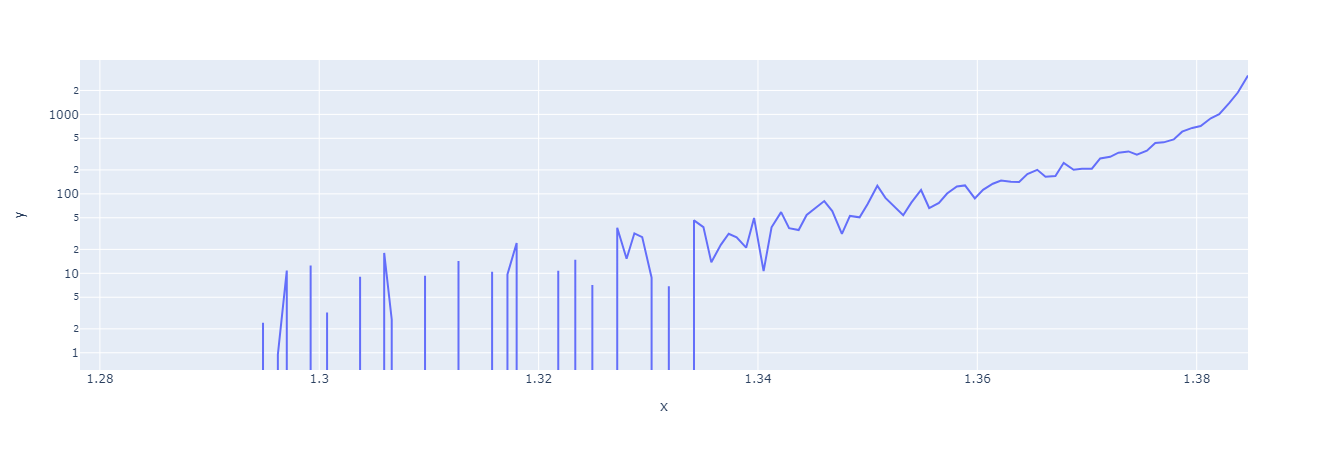

In [12]:
energy = ((cn.h * cn.c)/ (wavelength * 1e-9))/cn.e #convert nm to m


fig5 = px.line(x = energy, y = alpha, log_y = True)
fig5.show()

This is instructive, as it tells us only a small amount of noise can result in the log plot being remarkably distorted.

Let's use a smaller amount of noise and try again.

### Finding $\alpha$ using a smaller amount of noise

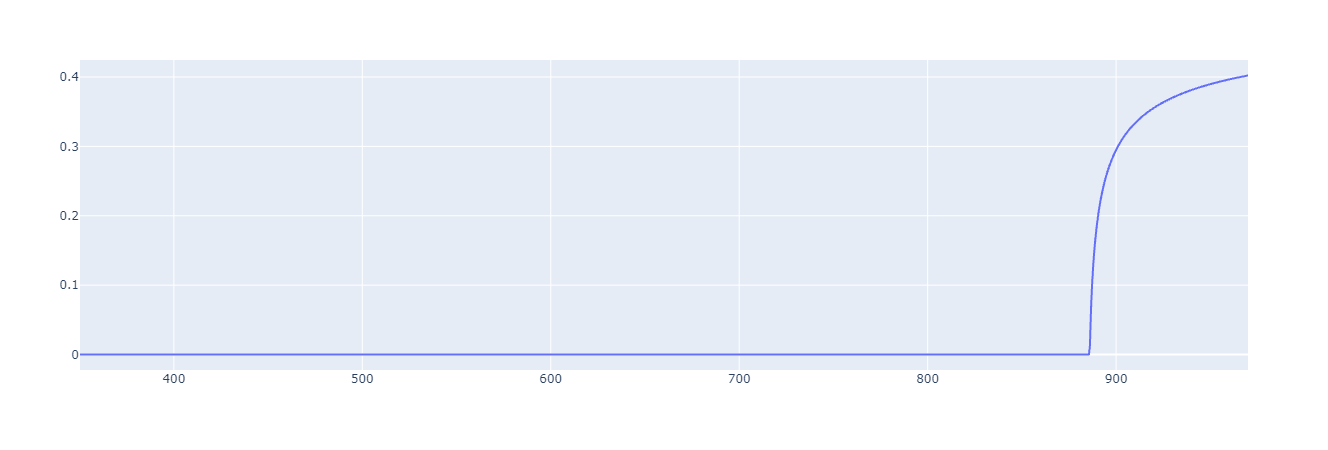

In [13]:
a = 885
n = 0.5
b = 0.5

x = df["Wavelength"].values
y = df["Signal"].values

len(x)

T = np.piecewise(x, [x < a+1, x >= a+1], [0, lambda x: ((x-a)**n)/((x-a)**n+1)-b])

# Get first index of mask being greater than 0
index = np.where(T > 0)[0][0]

# Get length of non-zero slice
nonzero_length = len(T[index :])

# Generate noise
noise = np.random.normal(0,0.0001,nonzero_length)

# Generate noisy mask
T_noisy = T
#T_noisy[index : ] += noise

# Plot
fig6 = px.line(x = x, y = T_noisy,
              labels = {
                 "x" : r"$\lambda \; \text{(nm)}$",
                 "y" : r"$T$"
             })
fig6.show()

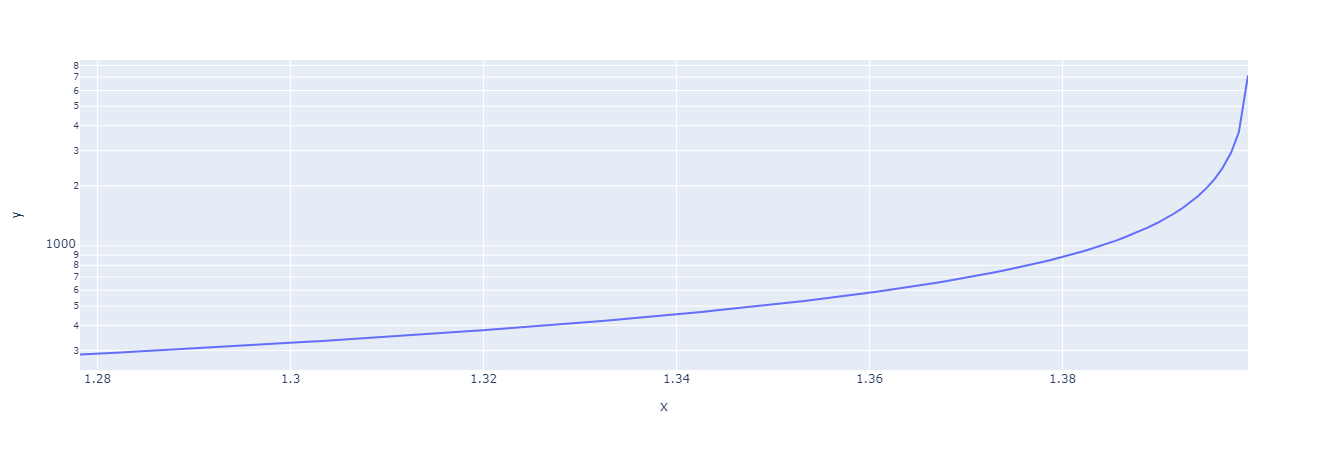

In [17]:
# Find first nonzero element as before
index = np.where(T > 0)[0][0]

# Create new slices of T and Wavelength
wavelength = (df["Wavelength"].values)[index :]
T = T_noisy[index :]

x = 0.50e-3

alpha = -1/x *np.log(1/(2*T*R**2) * (((1-R)**4 + 4 * T**2 * R**2)**(1/2) - (1-R)**2)) 

energy = ((cn.h * cn.c)/ (wavelength * 1e-9))/cn.e #convert nm to m

fig7 = px.line(x = energy, y = alpha, log_y = True)
fig7.show()

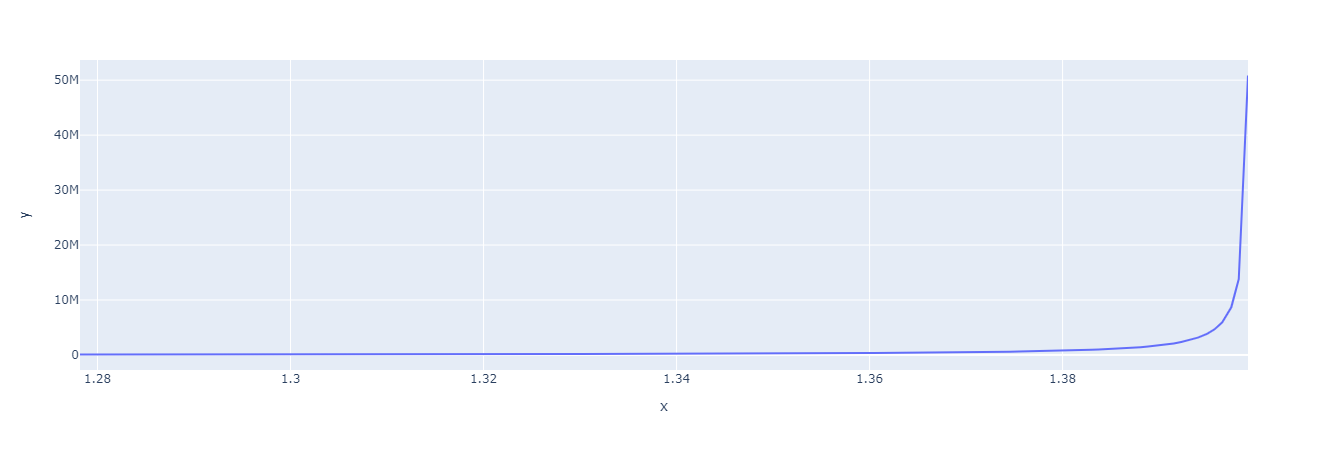

In [15]:
alpha_plot = alpha**2

fig8 = px.line(x = energy, y = alpha_plot)
fig8.show()

The general shape of the graph is similar to what we would expect for GaAs, however the linear region isn't as pronounced in this data compared to the Figure in the reference paper:

![title](img/alpha.png)

This suggests we need as many data points as possible within the high optical energy region.